<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommend that you set the runtime type in Colab to GPU, otherwise everything takes at least 5x as long to train

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

adapted from notebook https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb

## Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#imports
!pip install hdf5storage
import hdf5storage 

import pandas as pd
import numpy as np

#for matrix manipulation
!pip install awkward
import awkward as ak


from numpy.ma.core import floor


from sklearn.model_selection import train_test_split

#tsai for time series classification (Time Series AI)
!pip install tsai
from tsai.all import *
computer_setup()

from os import listdir

Mounted at /content/drive
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 11.7 MB 13.2 MB/s 
     |████████████████████████████████| 234 kB 11.8 MB/s 
     |████████████████████████████████| 187 kB 43.0 MB/s 
     |████████████████████████████████| 2.5 MB 47.2 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
os             : Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.0
fastai         : 2.5.5
fastcore       : 1.3.29
torch          : 1.10.0+cu111
n_cpus         : 2
device         : cuda (Tesla K80)


## Prepare data 🔢

In [22]:
#get the root folder and the filenames for our raw data mat files
root_path = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Stimulus_Features/allgood_but_orientation_edge_artifacts/' # temporarily pathing to subfolder
file_paths = listdir(root_path)
file_paths = [f for f in file_paths if '.mat' in f]

In [23]:
#verify each file has the features we need
for f in file_paths:
  results_file = hdf5storage.loadmat(root_path + f)
  print(f)
  print(results_file.keys())

210728_0_stim_20220309T002951_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210731_0_stim_20220308T120131_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210802_0_stim_20220308T122044_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210808_0_stim_20220309T012702_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210809_2_stim_20220308T131617_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210815_0_stim_20220308T134319_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210815_1_stim_20220308T140826_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8'])
210816_0_stim_20220308T143121_.mat
dict_keys(['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'st

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In [24]:
#function to use later - breaks each individual stack into sections of length (chunk_size)
#if the stack can't be broken up into chunks of the same size, we drop the final chunk in a separate step

#https://stackoverflow.com/questions/64100160/numpy-split-array-into-chunks-of-equal-size-with-remainder
def build_chunks(arr, chunk_size, axis=1):
     return np.split(arr, 
                     range(chunk_size, arr.shape[axis], chunk_size), axis=axis)

This cell will loop through the mat files for each movie and:

1. record the number of roi's, stacks, and frames in the movie   
2. extract the data from each key and each stack (response and all stimuli)
3. split each individual roi/stack recording into chunks of size specified in chunksize
4. reshape the matrix into the necessary (# of observations x # of features x # of frames) format for the models
5. Collect the cell type labels from the associated CSV (one label per roi)
6. Repeat each individual label to align with the repeating stacks and the number of chunks created
7. Combine labels, roi #'s, and movie ID's into a dataFrame
8. Combine the matrices and the labels from all movies into a single dataset

makes heavy use of numpy.stack(), documented here: https://numpy.org/doc/stable/reference/generated/numpy.stack.html








In [25]:
#declare the length of the chunks we want to use in the models - 
#found that 100-200 is best for InceptionTimePlus, probably 120
chunksize = 120

#set empty list to hold movie matrices
movielist = []
#set empty df to hold cell labels
labels_df = pd.DataFrame()


#loop through each movie
for f in file_paths:
  print(f)

  #read the movie from the mat file and create a list of the keys to loop through
  results_file = hdf5storage.loadmat(root_path + f)
  keys = list(results_file.keys())

  #get number of frames in the movie
  num_frames = results_file[keys[0]][0,1][0].shape[0]

  #get number of stacks
  num_stacks = results_file[keys[0]].shape[1]

  #get number of rois
  num_rois = results_file[keys[0]][0,0].shape[0]

  #set an empty list to hold the matrices from each key
  roi_stack_list = []

  for key in keys:
    #each key contains one matrix for each stack, each stack matrix is shape (# roi's x # of frames)

    #make a list containing each stack matrix. length of the list is the number of stacks
    stacks = [stack for stack in results_file[key][0]]

    #stack the stacks into a matrix with shape (# of roi's x # of stacks x # of frames)
    roi_stack = np.stack(stacks, axis = 1 )

    #we're treating one roi in one stack as an observation, so each movie contains (# of rois * # of stacks) total roi's
    #break the stacks up so the new shape is (# of roi's total x # of frames) 
    roi_stack = roi_stack.reshape(num_stacks * num_rois, num_frames)

    """
    now the matrix contains each roi in each stack's data for a single feature
    shape at this point is (total number of roi's x number of frames)
    where each roi is really just one roi in one stack
    """
    

    #split the frames of each stack into chunks length (chunksize)
    #using the function defined above
    chunks = build_chunks(roi_stack, chunksize)

    #remove chunks that are not the length (chunksize) (the remainder left over at the end of the stack)
    chunks = [chunk for chunk in chunks if chunk.shape[1] == chunksize]

    #stack the new chunk matrices back into one matrix. currently shape is (# of roi's  X # of chunks x chunksize (frames))
    chunks = np.stack(chunks, axis=1)

    #reshape each roi chunk so matrix is now (roi x frames)
    chunks = chunks.reshape(chunks.shape[0]*chunks.shape[1], chunks.shape[2])


    #the matrix now contains each chunk's data for a single feature over whatever time perios was specified
    """
    now the matrix contains each chunk in each roi's data for a single feature over whatever time period was specified
    shape at this point is (total number of chunks x chunksize)
    where each chunk is is a segment of a single roi's data over some period of time
    """    

    #add the matrix created for this key to the master list of matrices for this movie as we loop through it's keys
    roi_stack_list.append(chunks)


  #After we've looped through all the features in a single movie and added its individual feature matrices to the list
  #stack the list of feature matrices on top of each other to create a matrix that's (# of observations x # of features x # of frames)
  movie = np.stack(roi_stack_list, axis=1)

  #add the matrix that holds all the reformatted data for this movie to the list that holds each movie's matrix
  #will be combined into a single matrix after we've extracted each movie
  movielist.append(movie)



  #get cell labels for the movie and add to the labels dataFrame

  #folder that holds the roi labels for all movies
  labels_folder = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'

  #create a movie_ID from the date and the fly index of the filename
  movie_ID = "_".join(f.split('_',2)[:2])

  #get the filename of the csv that has the labels for this movie
  label_file = [f for f in listdir(labels_folder) if movie_ID in f and '.csv' in f][0]

  #read the csv to get the roi labels (in the same order as the .mat file)
  labels_csv = pd.read_csv(labels_folder+label_file)

  #save the labels and roi_numbers into lists, each is length (# of roi's)
  roi_labels = list(labels_csv['label'])
  roi_numbers = list(labels_csv['index']+1)


  #stretch the list to repeat each roi label to match the number of stacks and the number of chunks created
  #the formatting and reshaping of these labels needs to match how the matrices end up after the transformations above

  #this is hard to parse, but basically for each roi label, it now needs to be repeated once for every stack,
    #but also once for every chunk we created from that roi
  #so each roi gets repeated (# of stacks * # of chunks) times
  #the number of chunks created for each roi in each stack is the (length of the stack / the chunksize), rounded down since we drop the remainder

  chunks_per_stack = int(floor((num_frames/chunksize)))

  roi_labels = [roi for roi in roi_labels for i in range(num_stacks * chunks_per_stack)]
  roi_numbers = [roi for roi in roi_numbers for i in range(num_stacks * chunks_per_stack)]
  

  #create a list that holds the movie ID for each record as well
  movie_IDs = [movie_ID] * num_rois * num_stacks * int(floor((num_frames/chunksize)))

  #combine the labels, roi numbers, and movie ID into a dataFrame
  labels = pd.DataFrame(data = {'label': roi_labels,
                                      'roi_number': roi_numbers,
                                      'movie_ID': movie_IDs})
  
  #Add the label dataFrame created for this movie to the master dataFrame that will hold the labels for all movies
  labels_df = labels_df.append(labels)

#Now that we've extracted each movie as a matrix,
#combine all movies into one concatenated matrix with (obs x features x frames) dimensions
movie = np.concatenate(movielist)

210728_0_stim_20220309T002951_.mat
210731_0_stim_20220308T120131_.mat
210802_0_stim_20220308T122044_.mat
210808_0_stim_20220309T012702_.mat
210809_2_stim_20220308T131617_.mat
210815_0_stim_20220308T134319_.mat
210815_1_stim_20220308T140826_.mat
210816_0_stim_20220308T143121_.mat
210816_1_stim_20220308T150735_.mat


In [26]:
print(movie.shape)
print(labels_df.shape)

(49851, 9, 120)
(49851, 3)


In [27]:
#replace nan's with zeros (only in stim5)
movie = np.nan_to_num(movie)

In [28]:
# need to do more tests to verify order is what I think it is
results_file = hdf5storage.loadmat(root_path + file_paths[0])
sum(movie[0][0] == results_file['resp'][0][0][0][:chunksize])

120

In [29]:
#train/test split the observations
X_train, X_test, y_train, y_test = train_test_split(movie, labels_df['label'].to_numpy(), test_size=0.2, random_state=42)

#this is a convenience function from the tsai demo, it combines train/test back into one matrix and holds the splits separately
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [30]:
#declare any transformations we're going to do in-line as the model trains
#no transformations on X, but we're going to encode the labels as categories (I think this one-hot encodes but not sure)
tfms  = [None, [Categorize()]]

#create a dataset object from the X and y matrices, the splits, and the transformations we're doing
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

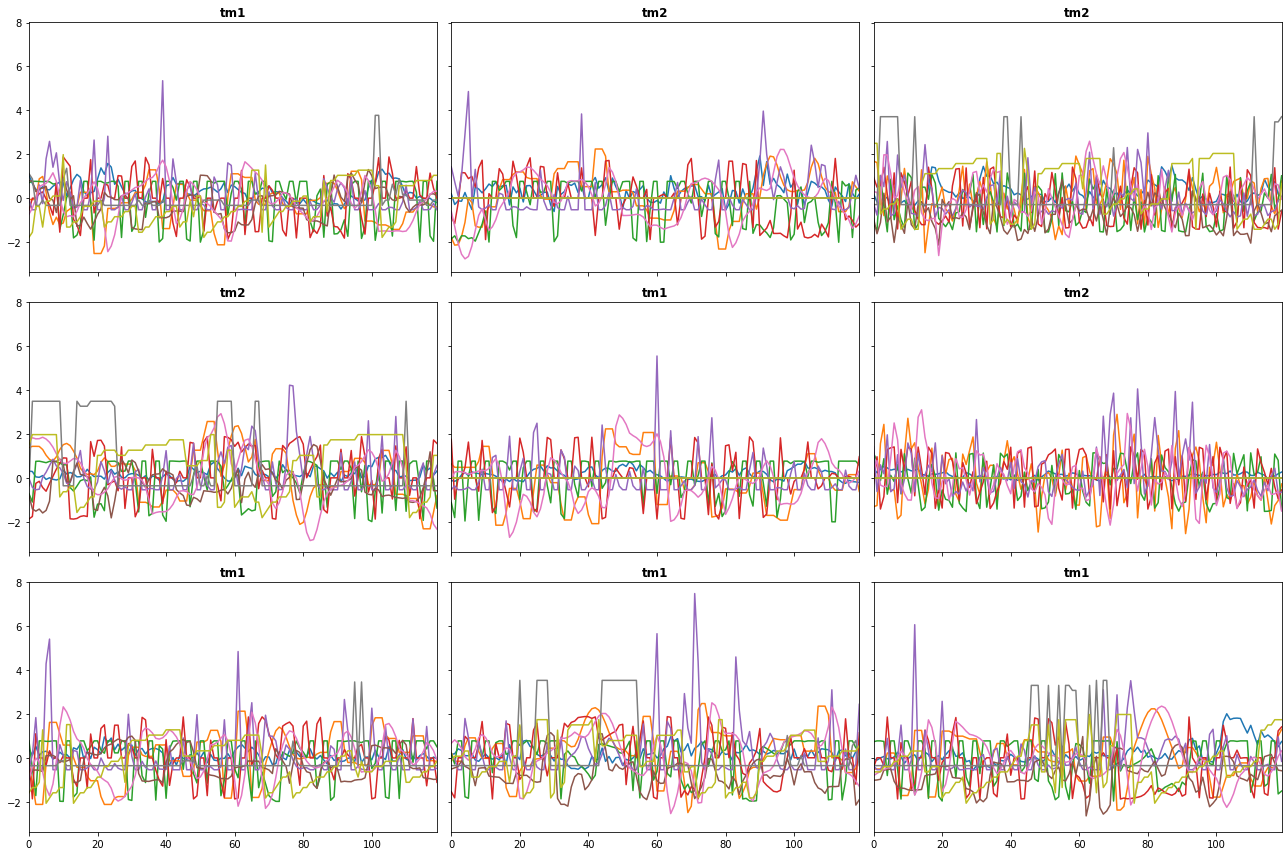

In [31]:
#method for the model to pull from the dataset object in batches for training
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])

#visualize the traces for each observation
dls.show_batch(sharey=True)

try learning using InceptionTime, a CNN with transformer modules that look at varying lengths of time all at once

this is an unofficial implementation within the tsai package

currently this is just using the model architecture and training a fresh model

https://arxiv.org/pdf/1909.04939.pdf

https://github.com/hfawaz/InceptionTime

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.981148,0.976220,0.611975,0.459653,00:25
1,0.816218,0.864402,0.654699,0.527899,00:24
2,0.727384,0.814063,0.682279,0.590582,00:24
3,0.670944,0.845479,0.688597,0.465783,00:25
4,0.603145,0.665756,0.723498,0.669773,00:25
5,0.573624,0.530704,0.781867,0.690406,00:25
6,0.508864,0.559680,0.781466,0.732890,00:25
7,0.469449,0.528473,0.797713,0.726320,00:25
8,0.431846,0.544258,0.787985,0.752037,00:25
9,0.398052,0.437979,0.820680,0.791569,00:25


,train_loss,valid_loss,accuracy,balanced_accuracy_score
24,0.035345,0.543446,0.853174,0.827292


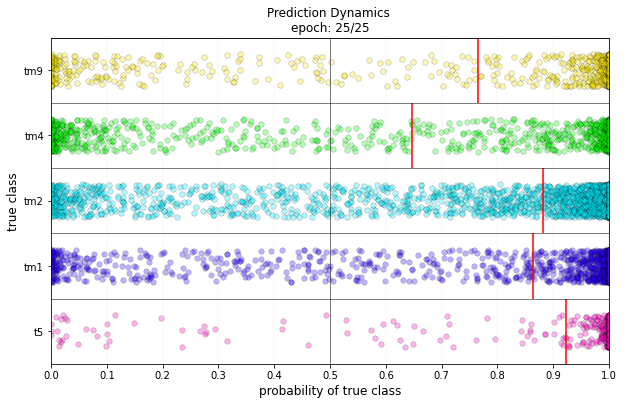

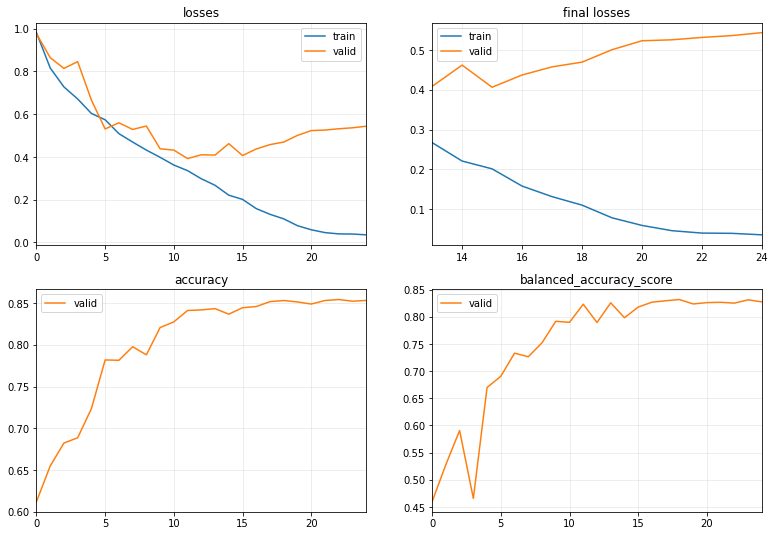

In [32]:
#declare the model object
model = InceptionTimePlus(dls.vars, dls.c)

#create the "learner" that packages the model, training methods, and visualizations
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics(show_perc=1))

#train for 11 epochs with a max learning rare of .001
learn.fit_one_cycle(25, lr_max=1e-3)

#plot the learning metrics
learn.plot_metrics()

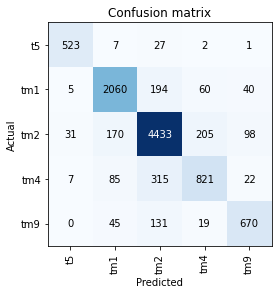

In [33]:
#confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

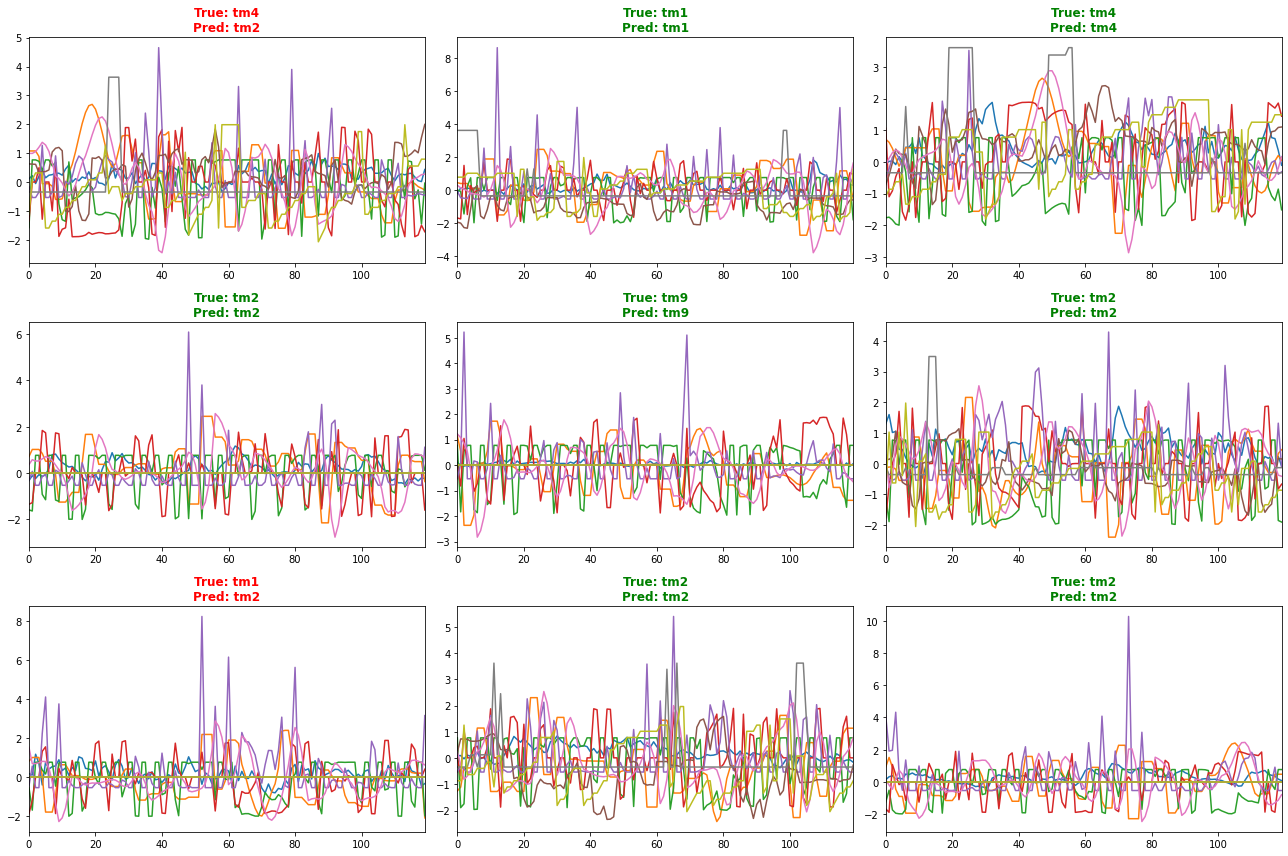

In [35]:
#visualize some predictions with labels
learn.show_results()

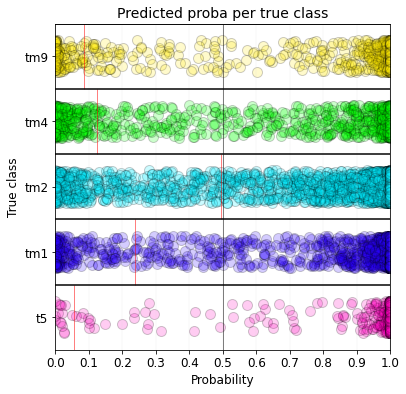

In [34]:
#not sure exactly what this communicates
learn.show_probas()

# TO-DO: run predictions on each chunk, roll predictions up into the roi/stack level and the overall roi level to check predictive power

# testing different chunk sizes using a loop over the whole extraction and modelling process

In [ ]:
# #Giant loop to test multiple frame chunk sizes - found that 100-200 seems to work best, 120 was good

# chunks_list = [10, 20, 40, 120, 200, 400, 800, 1000]  

# for chunksize in chunks_list:  
#   #chunksize loop
#   movielist = []
#   labels_df = pd.DataFrame()
#   #chunksize = 5000

#   print(f"Chunk size: {chunksize}")


#   for f in file_paths:
#     print(f)

#     results_file = hdf5storage.loadmat(root_path + f)
#     keys = list(results_file.keys())

#     #get number of frames in the movie
#     num_frames = results_file[keys[0]][0,1][0].shape[0]

#     #get number of stacks
#     num_stacks = results_file[keys[0]].shape[1]

#     #get number of rois
#     num_rois = results_file[keys[0]][0,0].shape[0]

#     roi_stack_list = []

#     for key in keys:
#       #each key contains different matrices for each stack, each stack matrix is (# roi's x # of frames)

#       #make a list of each stack matrix. length of the list is the number of stacks
#       stacks = [stack for stack in results_file[key][0]]
#       #stack the stacks into a matrix w shape (# of roi's x # of stacks x # of frames)
#       roi_stack = np.stack(stacks, axis = 1 )
#       #break the stacks up so the new shape is (# of rois total x # of frames) 
#       roi_stack = roi_stack.reshape(num_stacks * num_rois, num_frames)

      

#       #split the frames of each stack into chunks of 40 frames
#       chunks = build_chunks(roi_stack, chunksize)
#       #remove chunks that are not the length 40 (remainder left over at the end of the stack)
#       chunks = [chunk for chunk in chunks if chunk.shape[1] == chunksize]
#       #stack the new chunk matrices back into one matrix. currently shape is (roi X chunks x frames)
#       chunks = np.stack(chunks, axis=1)
#       #reshape each roi chunk so matrix is now (roi x frames)
#       chunks = chunks.reshape(chunks.shape[0]*chunks.shape[1], chunks.shape[2])

#       #add the matrix created for this key to the list of matrices
#       roi_stack_list.append(chunks)

#     #stack the list of key matrices on top of each other to create a matrix that's (# of observations x # of features x # of frames)
#     movie = np.stack(roi_stack_list, axis=1)

#     movielist.append(movie)


#     #get labels for the movie and add to list

#     #folder that holds the roi labels for all movies
#     labels_folder = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'

#     movie_ID = "_".join(f.split('_',2)[:2])

#     #get the filename of the csv that has the labels for this movie
#     label_file = [f for f in listdir(labels_folder) if movie_ID in f and '.csv' in f][0]

#     #read the csv to get the roi labels (in the same order)
#     labels_csv = pd.read_csv(labels_folder+label_file)
#     roi_labels = list(labels_csv['label'])
#     roi_numbers = list(labels_csv['index']+1)


#     #stretch the list to repeat each roi label to match the number of stacks
#     roi_labels = [roi for roi in roi_labels for i in range(num_stacks * int(floor((num_frames/chunksize))))]
#     roi_numbers = [roi for roi in roi_numbers for i in range(num_stacks * int(floor((num_frames/chunksize))))]

#     movie_IDs = [movie_ID] * num_rois * num_stacks * int(floor((num_frames/chunksize)))

#     labels = pd.DataFrame(data = {'label': roi_labels,
#                                         'roi_number': roi_numbers,
#                                         'movie_ID': movie_IDs})
    
#     labels_df = labels_df.append(labels)

#   #combine all movies into one concatenated matrix with (obs x features x frames) dimensions

#   movie = np.concatenate(movielist)

#   movie = np.nan_to_num(movie)

#   X_train, X_test, y_train, y_test = train_test_split(movie, labels_df['label'].to_numpy(), test_size=0.2, random_state=42)
#   X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

#   tfms  = [None, [Categorize()]]
#   dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

#   dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])

#   #try learning inceptiontimePlus?
#   model = InceptionTimePlus(dls.vars, dls.c)
#   learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics(show_perc=1))
#   learn.fit_one_cycle(11, lr_max=1e-3)
#   learn.plot_metrics()


#   interp = ClassificationInterpretation.from_learner(learn)
#   interp.plot_confusion_matrix()

# unfinished code to verify that the cell labels line up with the chunks correctly

In [ ]:
# #read in one file
# results_file = hdf5storage.loadmat(root_path + file_paths[0])
# keys = list(results_file.keys())

# #get number of frames in the movie
# num_frames = results_file[keys[0]][0,1][0].shape[0]

# #get number of stacks
# num_stacks = results_file[keys[0]].shape[1]

# #get number of rois
# num_rois = results_file[keys[0]][0,0].shape[0]

# print(num_stacks, num_rois, num_frames)

In [ ]:
# for f in file_paths:
#   print(f)
#   results_file = hdf5storage.loadmat(root_path + f)
#   for x in results_file['stim5'][0][0]:
#     print(sum(x))
#     print(sum(np.isnan(x)))

In [ ]:
# #each key contains different matrices for each stack, each stack matrix is (# roi's x # of frames)
# keys = list(results_file.keys())

# #get number of frames in the movie
# num_frames = results_file[keys[0]][0,1][0].shape[0]

# #get number of stacks
# num_stacks = results_file[keys[0]].shape[1]

# #get number of rois
# num_rois = results_file[keys[0]][0,0].shape[0]
# #make a list of each stack matrix. length of the list is the number of stacks
# stacks = [stack for stack in results_file['resp'][0]]
# #stack the stacks into a matrix w shape (# of roi's x # of stacks x # of frames)
# roi_stack = np.stack(stacks, axis = 1 )
# print(roi_stack.shape)
# #break the stacks up so the new shape is (# of rois total x # of frames) 
# roi_stack = roi_stack.reshape(num_stacks * num_rois, num_frames)

# roi_stack.shape

In [ ]:
# from numpy.ma.core import floor
# floor((5513/chunksize)) * num_rois * num_stacks

In [ ]:
# chunksize = 100
# test = build_chunks(roi_stack, chunksize)
# test = [chunk for chunk in test if chunk.shape[1] == chunksize]
# test = np.stack(test, axis=1)
# print(test.shape)
# test = test.reshape(test.shape[0]*test.shape[1], test.shape[2])
# print(test.shape)

In [ ]:
# test.shape

In [ ]:
# plt.plot(test[55])

In [ ]:
# plt.plot(roi_stack[1][:100])

In [ ]:
# plt.plot(results_file['resp'][0][0][1][:100])

In [ ]:
# #folder that holds the roi labels for all movies
# labels_folder = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'

# movie_ID = "_".join(file_paths[0].split('_',2)[:2])



# #get the filename of the csv that has the labels for this movie
# label_file = [f for f in listdir(labels_folder) if movie_ID in f and '.csv' in f][0]

# #read the csv to get the roi labels (in the same order)
# labels_csv = pd.read_csv(labels_folder+label_file)
# roi_labels = list(labels_csv['label'])
# roi_numbers = list(labels_csv['index']+1)


# #stretch the list to repeat each roi label to match the number of stacks
# roi_labels = [roi for roi in roi_labels for i in range(num_stacks)]
# roi_numbers = [roi for roi in roi_numbers for i in range(num_stacks)]
# movie_IDs = [movie_ID] * 9 * 14

# labels_df = pd.DataFrame(data = {'label': roi_labels,
#                                     'roi_number': roi_numbers,
#                                     'movie_ID': movie_IDs})
# len(labels_df)

# Everything below this cell is the original tutorial -useful to see how the tsai pipeline works

### Download data ⬇️

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.


In [ ]:
print(get_UCR_univariate_list())

['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'I

In [ ]:
print(get_UCR_multivariate_list())

['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

return_split determines whether UCR data will be returned already split between train and test or not.

In [ ]:
# dataset id
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
X.shape, y.shape, splits

((360, 24, 51),
 (360,),
 ((#180) [0,1,2,3,4,5,6,7,8,9...],
  (#180) [180,181,182,183,184,185,186,187,188,189...]))

In [ ]:
X_train, y_train, X_test, y_test  = get_UCR_data(dsid, return_split=True)

you can use this convenience function to get X, y and splits:

In [ ]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Prepare datasets 💿

The first step is to create datasets. This is very easy to do in v2. 

In TS classification problems, you will usually want to use an item tfm to transform y into categories.

We'll use inplace=True to preprocess data at dataset initialization. This will significantly speed up training. 

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

We'll now build the dataloaders that will create batches of data.

You will need to pass:

* datasets: usually 2 - train and valid -  or 1 - test or unlabeled- depending on the problem
* batch size(s): you may pass a single value (will will be appied to all dls, or different values, one for each dl.
* batch_tfms (same as after_batch): you may decide to pass some tfms at the batch level. In this case for example, we'll standardize the data (0 mean and 1 std). You may get more details on how these transforms work in the transforms nb.
* num workers: num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process. This will depend on your machine, dataset, etc. You may want to start with 0, and test other values to see how to train faster. For me, 0 works better.

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

### Visualize data

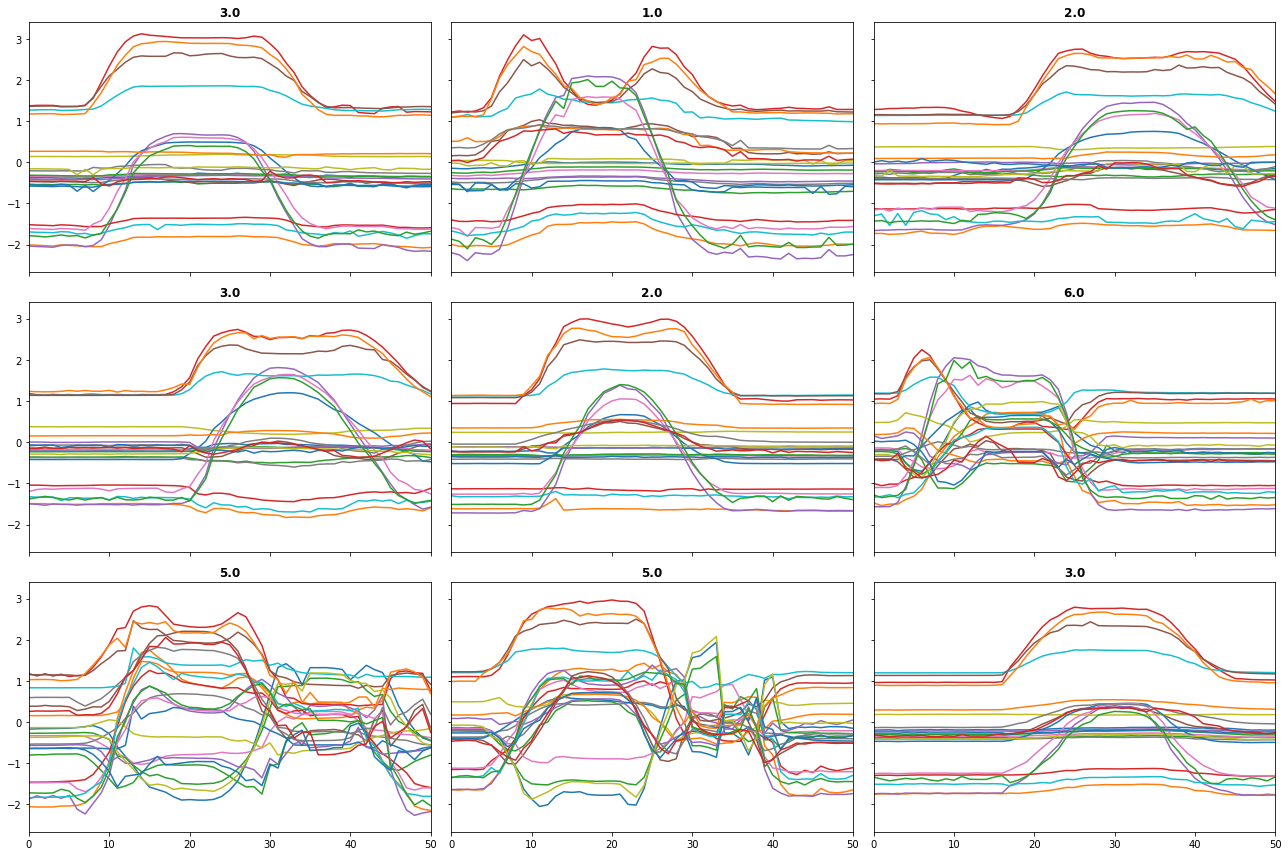

In [ ]:
dls.show_batch(sharey=True)

## Build learner 🏗

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

## Train model 🚵🏼‍

### LR find 🔎

In [ ]:
learn.load('stage0')
learn.lr_find(suggestions=False)

TypeError: ignored

### Train 🏃🏽‍♀️

In [ ]:
learn.fit_one_cycle(25, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,1.971959,1.825324,0.105556,00:02
1,1.861932,1.817775,0.100000,00:01
2,1.710140,1.806491,0.111111,00:01
3,1.521706,1.785757,0.138889,00:01
4,1.338657,1.746803,0.366667,00:01
5,1.191411,1.671111,0.577778,00:01
6,1.061170,1.546168,0.727778,00:01
7,0.961539,1.375402,0.744444,00:01
8,0.882827,1.200506,0.788889,00:01
9,0.809322,1.024153,0.838889,00:01


Path('models/stage1.pth')

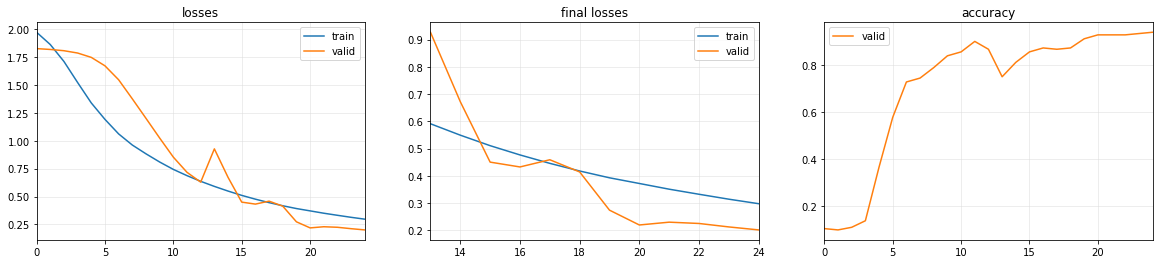

In [ ]:
learn.recorder.plot_metrics()

Let's pretend we need to end the working session now for some reason, but we'd like to continue working with this datasets and learner in the future. 

To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status: 

In [ ]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

As soon as we've done this, we can end the session, and continue at any time in the future. 

Let's simulate that we need to end the session now:

In [ ]:
del learn, dsets, dls

Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

In [ ]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:24, len:51),
 TensorCategory([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
         1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
         2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
         0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
         1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
         0, 3, 4, 3, 1, 2, 2, 2], device='cuda:0'))

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.0076, 0.0145, 0.0160, 0.9461, 0.0115, 0.0043],
         [0.0067, 0.0053, 0.0077, 0.0161, 0.9472, 0.0169],
         [0.0022, 0.0030, 0.0022, 0.0023, 0.0035, 0.9868],
         ...,
         [0.0054, 0.0065, 0.0060, 0.0153, 0.9494, 0.0174],
         [0.0062, 0.0127, 0.0128, 0.9542, 0.0103, 0.0038],
         [0.0061, 0.0191, 0.0181, 0.8672, 0.0796, 0.0098]]),
 TensorCategory([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
         1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
         2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
         0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
         1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
         0, 3, 4, 3, 1, 2, 2, 2, 2, 0, 4, 0, 0, 1, 3, 4, 4, 2, 1, 1, 1, 4, 4, 3,
         1, 4, 0, 4, 5, 5, 1, 5, 3, 3, 5, 5, 4, 3, 5, 1, 3, 2, 3, 0, 1, 3, 0, 2,
         5, 2, 1, 5, 3, 1, 0, 5, 2, 4, 3, 3]),
 tensor(

We can confirm the learner has the same status it had at the end of training, by confirming the validation accuracy is the same:

In [ ]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.9222)

Great! It's the same. This means we have now the learner at the same point where we left it.

## Visualize results 👁

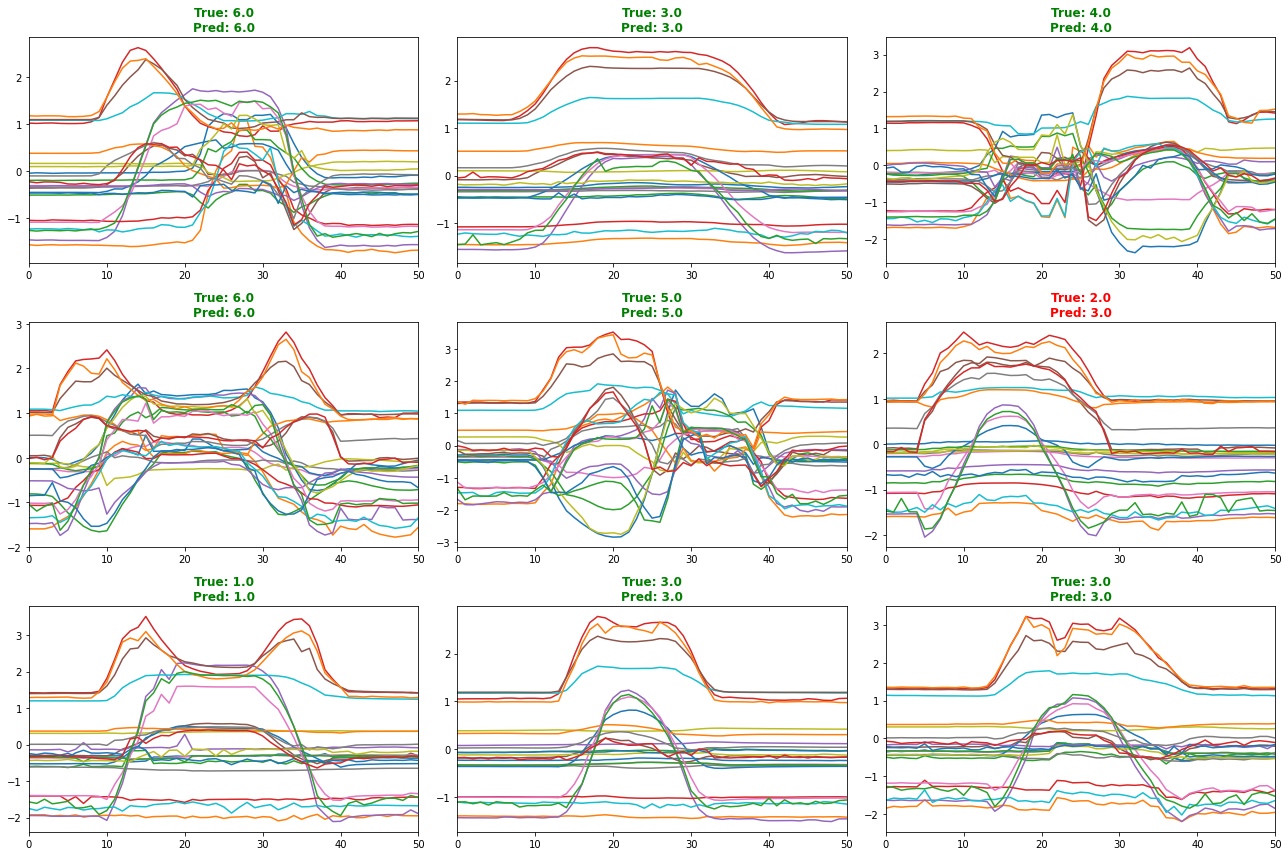

In [ ]:
learn.show_results()

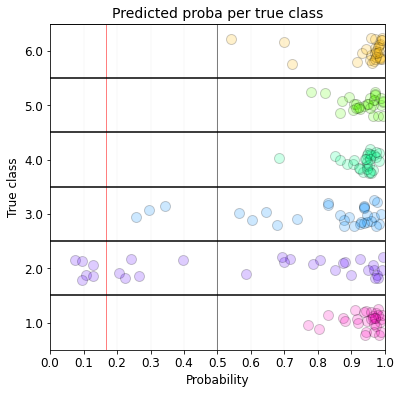

In [ ]:
learn.show_probas()

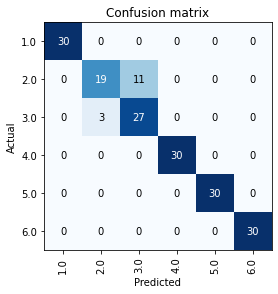

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=3)

[('2.0', '3.0', 11), ('3.0', '2.0', 3)]

## Inference on additional data 🆕

Let's say we want to predict labels on new data. Let's see how this works.

We may have additional data (test set) where we want to check our performance. In this case, we'd add a labeled dataset:

In [ ]:
# Labeled test data
test_ds = valid_dl.dataset.add_test(X, y)# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0], device='cuda:0'))

By selecting the valid dataset (valid_dl.dataset) we ensure that the same tfms applied to the valid data will be applied to the new data.

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[4.1531e-03, 1.1060e-02, 9.1766e-03, 9.6424e-01, 7.8360e-03, 3.5367e-03],
         [1.5513e-03, 9.0474e-03, 9.8747e-01, 8.4518e-04, 7.8987e-04, 2.9669e-04],
         [6.9148e-03, 5.1244e-02, 9.3375e-01, 3.0172e-03, 3.2914e-03, 1.7787e-03],
         ...,
         [5.3600e-03, 6.4797e-03, 6.0490e-03, 1.5313e-02, 9.4938e-01, 1.7417e-02],
         [6.1849e-03, 1.2748e-02, 1.2783e-02, 9.5419e-01, 1.0297e-02, 3.7969e-03],
         [6.0839e-03, 1.9118e-02, 1.8110e-02, 8.6721e-01, 7.9642e-02, 9.8340e-03]]),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0, 5, 3, 0, 1, 4, 5, 5, 0, 5, 3, 5, 1, 0, 0

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.961111


If data is unlabeled, we'd just do this: 

In [ ]:
# Unlabeled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51),)

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

tensor([[4.1531e-03, 1.1060e-02, 9.1766e-03, 9.6424e-01, 7.8360e-03, 3.5367e-03],
        [1.5513e-03, 9.0474e-03, 9.8747e-01, 8.4518e-04, 7.8987e-04, 2.9669e-04],
        [6.9148e-03, 5.1244e-02, 9.3375e-01, 3.0172e-03, 3.2914e-03, 1.7787e-03],
        ...,
        [5.3600e-03, 6.4797e-03, 6.0490e-03, 1.5313e-02, 9.4938e-01, 1.7417e-02],
        [6.1849e-03, 1.2748e-02, 1.2783e-02, 9.5419e-01, 1.0297e-02, 3.7969e-03],
        [6.0839e-03, 1.9118e-02, 1.8110e-02, 8.6721e-01, 7.9642e-02, 9.8340e-03]])

## Summary ✅

This is all the code you need to train a TS model. As you can see, it's v2 is easier to use and faster compared to v1.

epoch,train_loss,valid_loss,accuracy,time
0,1.788165,1.787418,0.300000,00:01
1,1.693054,1.777232,0.311111,00:01
2,1.552933,1.764014,0.322222,00:01
3,1.395323,1.741449,0.333333,00:01
4,1.242469,1.699754,0.355556,00:01
5,1.104174,1.618201,0.550000,00:01
6,0.993408,1.491501,0.650000,00:01
7,0.904919,1.361391,0.655556,00:01
8,0.829823,1.156195,0.761111,00:01
9,0.764919,0.968861,0.794444,00:01


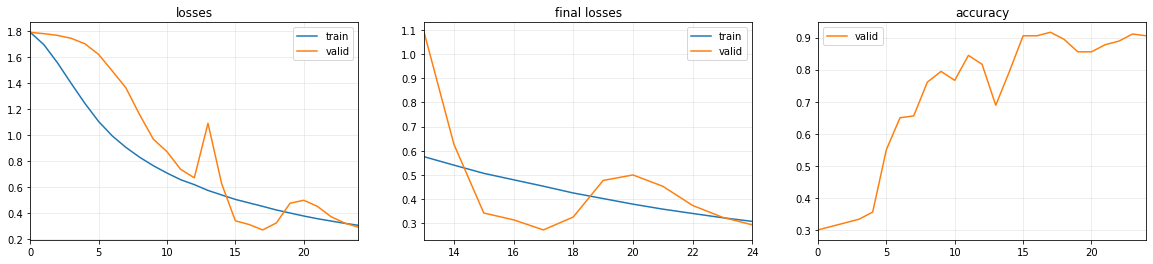

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()

## New scikit-learn-like API 🎉

As of `tsai` version 0.2.15 I have added a new scikit-learn-like API to further simplify the learner creation. 

I will prepare a new tutorial to further demonstrate how you can use the new API.

This is how you can use it for Time Series Classification: 

epoch,train_loss,valid_loss,accuracy,time
0,1.733282,1.794537,0.233333,00:01
1,1.628512,1.786765,0.233333,00:00
2,1.473072,1.774885,0.227778,00:00
3,1.303110,1.754300,0.244444,00:00
4,1.146412,1.715275,0.300000,00:00
5,1.020971,1.641930,0.450000,00:00
6,0.915315,1.522252,0.605556,00:00
7,0.844486,1.395301,0.672222,00:00
8,0.773786,1.220173,0.705556,00:00
9,0.709649,1.032716,0.822222,00:00


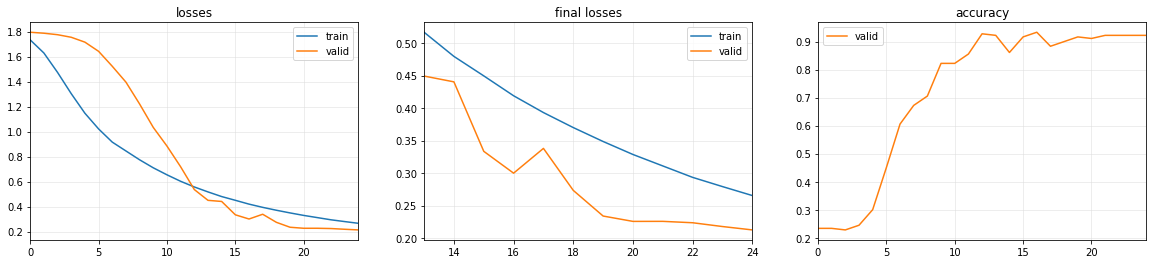

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=[TSStandardize()], arch=InceptionTime, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()

In [ ]:
X.shape

(360, 24, 51)

In [ ]:
y

memmap(['4.0', '3.0', '3.0', '4.0', '3.0', '5.0', '1.0', '6.0', '3.0',
        '2.0', '6.0', '1.0', '4.0', '6.0', '3.0', '2.0', '3.0', '2.0',
        '2.0', '6.0', '4.0', '3.0', '5.0', '4.0', '1.0', '6.0', '3.0',
        '5.0', '5.0', '5.0', '3.0', '5.0', '3.0', '5.0', '4.0', '5.0',
        '3.0', '1.0', '4.0', '6.0', '3.0', '4.0', '4.0', '6.0', '1.0',
        '6.0', '2.0', '1.0', '1.0', '6.0', '4.0', '1.0', '3.0', '3.0',
        '2.0', '1.0', '5.0', '1.0', '2.0', '5.0', '4.0', '5.0', '2.0',
        '5.0', '1.0', '6.0', '3.0', '1.0', '2.0', '1.0', '3.0', '4.0',
        '4.0', '3.0', '5.0', '2.0', '2.0', '3.0', '3.0', '6.0', '6.0',
        '1.0', '2.0', '5.0', '2.0', '2.0', '4.0', '5.0', '6.0', '4.0',
        '2.0', '3.0', '1.0', '3.0', '1.0', '5.0', '6.0', '6.0', '5.0',
        '5.0', '6.0', '4.0', '2.0', '1.0', '2.0', '2.0', '2.0', '6.0',
        '5.0', '4.0', '3.0', '4.0', '1.0', '3.0', '5.0', '5.0', '5.0',
        '4.0', '3.0', '6.0', '3.0', '1.0', '3.0', '4.0', '1.0', '6.0',
      